### Проект по e-commerce
Проанализировать совершенные покупки и ответить на следующие вопросы:

    1. Сколько у нас пользователей, которые совершили покупку только один раз? 
    2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
    3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
    4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
    5. Провести когортный анализ пользователей, выявить когорту с самым высоким retention на 3й месяц. 
    6. Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
from scipy import stats
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )


In [3]:
#таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
#совершаю первичный анализ данных в таблицах

In [4]:
#пропусков нет, данные в норме
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
# количество уникальных идентификаторов пользователей (аналог номера паспорта)
customers.customer_unique_id.nunique()

96096

In [6]:
# таблица заказов + перевод дат к типу datetime
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                                            'order_approved_at',
                                                                           'order_delivered_carrier_date',
                                                                           'order_delivered_customer_date',
                                                                           'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
#даты переведы верно, пропуски в датах order_approved_at, order_delivered_carrier_date,
#order_delivered_customer_date,order_estimated_delivery_date 
orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [8]:
orders.order_id.nunique()

99441

In [9]:
#уникальные значения колонки order_status
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [10]:
#расчет количества заказов по их статусам
count_order_status= orders.groupby('order_status', as_index=False)\
                          .agg({'order_id':'count'}) \
                          .sort_values('order_id', ascending=False)
count_order_status

,order_status,order_id
3,delivered,96478
6,shipped,1107
1,canceled,625
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен 
canceled —  отменён

In [11]:
#товарные позиции, входящие в заказы + перевод даты к типу datetime
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=["shipping_limit_date"])
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
#пропусков нет,дата переведна верно
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [13]:
# количество уникальных идентификаторов заказов
order_items.order_id.nunique()

98666

In [14]:
# количество уникальных ид товаров (аналог штрихкода)
order_items.product_id.nunique()

32951

In [15]:
#уникальные значения order_item_id
order_items.order_item_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

#### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

    Договор купли-продажи — это договор, по которому одна сторона (продавец) обязуется передать вещь (товар) в собственность другой стороне (покупателю), а покупатель обязуется принять этот товар и уплатить за него определённую денежную сумму (цену).
    Понятие покупки можно опрделить как приобретение чего-либо в собственность за деньги или иные ценности.
В нашем случае неклассический договор купли-продажи, а заключенный дистационным образом.
    Договор купли-продажи товара, заключенный дистанционным способом, считается исполненным с момента доставки товара 
в место, указанное в таком договоре, а если место передачи товара таким договором не определено, с момента доставки товара 
по месту жительства покупателя-гражданина или месту нахождения покупателя - юридического лица.
    Следовательно, под покупкой будем понимать исполненое действие по договору купли-продажи дистанционным способом - 
товар должен быть доставлен покупателю (order_status = delivered) и оплачен (из orders берем order_approved_at —  время подтверждения оплаты заказа), при этом, поскольку нас интересует покупка только один раз, будем использовать только customer_unique_id, у которых одна дата оплаты(order_approved_at).

In [16]:
customers_one_buy = customers.merge(orders)
customers_one_buy.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [17]:
#смотрим сколько уникальных значений у колонки customer_unique_id
customers_one_buy.customer_unique_id.nunique()

96096

In [18]:
#заполняем пропуски дат нулями
customers_one_buy[['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']] \
= customers_one_buy[['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].fillna(value = 0) 

In [19]:
#фильтруем данные по статусу заказа и подтверждению оплаты 1 раз
customers_one_buy_final =  customers_one_buy.query('order_status == "delivered" and order_approved_at != 0') \
                                            .groupby('customer_unique_id', as_index=False) \
                                            .agg({'order_id':'count','order_approved_at':'count'}) \
                                            .query('order_id == 1 and order_approved_at == 1')
customers_one_buy_final.head()

,customer_unique_id,order_id,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1
2,0000f46a3911fa3c0805444483337064,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,1


In [20]:
#проверка на количество
customers_one_buy_final.count()

customer_unique_id    90545
order_id              90545
order_approved_at     90545
dtype: int64

In [21]:
#проверка по уникальным значениям
customers_one_buy_final.nunique()

customer_unique_id    90545
order_id                  1
order_approved_at         1
dtype: int64

In [ ]:
ОТВЕТ: 90545 пользователей, которые совершили покупку только один раз

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

    Под причинами недоставки товара будем считать статусы:
    unavailable —  недоступен 
    canceled —  отменён, 
а также с пропущенным значением order_delivered_customer_date(время доставки заказа) 

In [22]:
# заполняем пропущенные значения в нужной нам колонке на 0
orders['order_delivered_customer_date'] = orders['order_delivered_customer_date'].fillna(value = 0)

In [23]:
# переводим дату к формату год и месяц
orders.order_purchase_timestamp = orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [24]:
#фильтруем данные по нужным нам статусам, а также оставлеям данные с пропуском времени доставки заказа
orders_not_deliver =  orders.query('order_status in ["unavailable","canceled"] and order_delivered_customer_date == 0')

In [25]:
orders_not_deliver.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11,2017-11-16 15:26:57,NaT,0,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08,2018-08-07 04:10:26,NaT,0,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01,2018-01-31 14:23:50,NaT,0,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01,2018-01-26 21:58:39,2018-01-29 22:33:25,0,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08,2017-08-17 00:15:18,NaT,0,2017-09-05


In [26]:
#проверяем, что ничего лишнего не осталось в данной колонке кроме 0
orders_not_deliver.order_delivered_customer_date.unique()

array([0], dtype=object)

In [27]:
#общее количество наших статусов
orders_not_deliver.order_status.count()

1228

In [28]:
#общее количество уникальных заказов
orders_not_deliver.order_id.nunique()

1228

In [29]:
#считаем кол-во недоставленных заказов по каждой причине за каждый месяц и выводим общее среднее значение для каждой причины
final_mean = orders_not_deliver.groupby(["order_purchase_timestamp", "order_status"], as_index=False) \
                                            .agg({"order_id": "count"}) \
                                            .groupby("order_status", as_index=False) \
                                            .agg({"order_id": "mean"}) 

In [30]:
final_mean

,order_status,order_id
0,canceled,25.791667
1,unavailable,29.000000


In [31]:
#выводим количество недоставленных заказов по месяцам и причинам недоставки
orders_not_deliver_final= orders_not_deliver.groupby(["order_purchase_timestamp", "order_status"], as_index=False) \
                                            .agg({"order_id": "count"}) \
                                            .sort_values("order_purchase_timestamp")
orders_not_deliver_final.head()

,order_purchase_timestamp,order_status,order_id
0,2016-09,canceled,2
1,2016-10,canceled,19
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10


Text(0, 0.5, 'Кол-во недоставленных заказов')

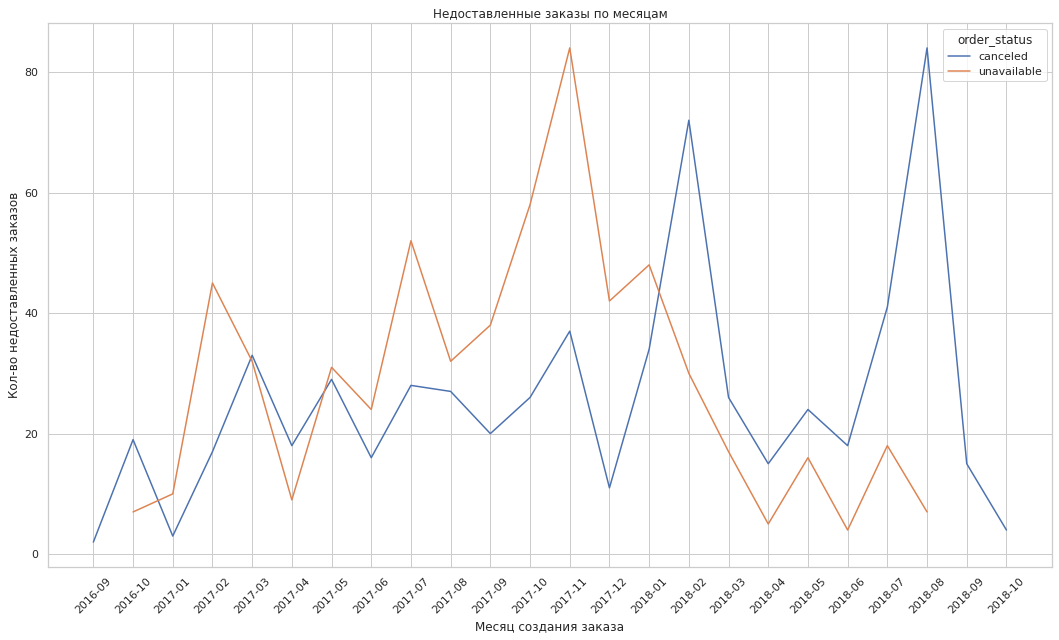

In [32]:
plt.figure(figsize = (18,10))
sns.lineplot(data=orders_not_deliver_final, x="order_purchase_timestamp", y="order_id", hue="order_status")
plt.xticks(rotation=45)
plt.title('Недоставленные заказы по месяцам')
plt.xlabel('Месяц создания заказа')
plt.ylabel('Кол-во недоставленных заказов')

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [33]:
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                                            'order_approved_at',
                                                                           'order_delivered_carrier_date',
                                                                           'order_delivered_customer_date',
                                                                           'order_estimated_delivery_date'])

In [34]:
most_buy = orders.merge(order_items)

In [35]:
# определяем день недели при подтверждении оплаты заказа
most_buy.order_approved_at = most_buy.order_approved_at.dt.day_name()

In [36]:
most_buy[['order_approved_at']] = most_buy[['order_approved_at']].fillna(value = 0)

In [37]:
# оставляем наши доставленные заказы, которые мы считаем за покупки
most_buy = most_buy.query('order_status == "delivered" and order_approved_at != 0')
most_buy.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,Monday,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,Thursday,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,Wednesday,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,Saturday,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,Tuesday,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [38]:
#проверяем сколько всего в таблице ид товара
most_buy.product_id.count()

110182

In [39]:
#проверяем уникальные ид товара
most_buy.product_id.nunique()

32213

In [40]:
#проверяем, что не осталось лишних значений
most_buy.order_approved_at.unique()

array(['Monday', 'Thursday', 'Wednesday', 'Saturday', 'Tuesday', 'Sunday',
       'Friday'], dtype=object)

In [41]:
#группируем данные по продукту и дню недели, определяем в какой день недели товар чаще всего покупается
most_buy_final = most_buy.groupby(["product_id", "order_approved_at"], as_index=False) \
                         .agg({"order_id": "count"}) \
                         .sort_values(by="order_id", ascending=False) \
                         .drop_duplicates(subset='product_id') \
                         .rename(columns={"order_approved_at" : 'day_of_week'})
most_buy_final

,product_id,day_of_week,order_id
40190,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
19709,53b36df67ebb7c41585e8d54d6772e08,Tuesday,104
15609,422879e10f46682990de24d770e7f83d,Tuesday,89
12793,368c6c730842d78016ad823897a372db,Thursday,80
35778,99a4788cb24856965c36a24e339b6058,Tuesday,78
...,...,...,...
23490,640fcadaeb5f06f26d6b07d366cebd34,Saturday,1
23491,6410668313e664e438837bf86363fcb9,Friday,1
23492,64118e924b5de8663f5cb1caad0abff8,Monday,1
23493,64123627d4116a2bc8284f1bc0a257f3,Saturday,1


Text(0, 0.5, 'Кол-во товаров')

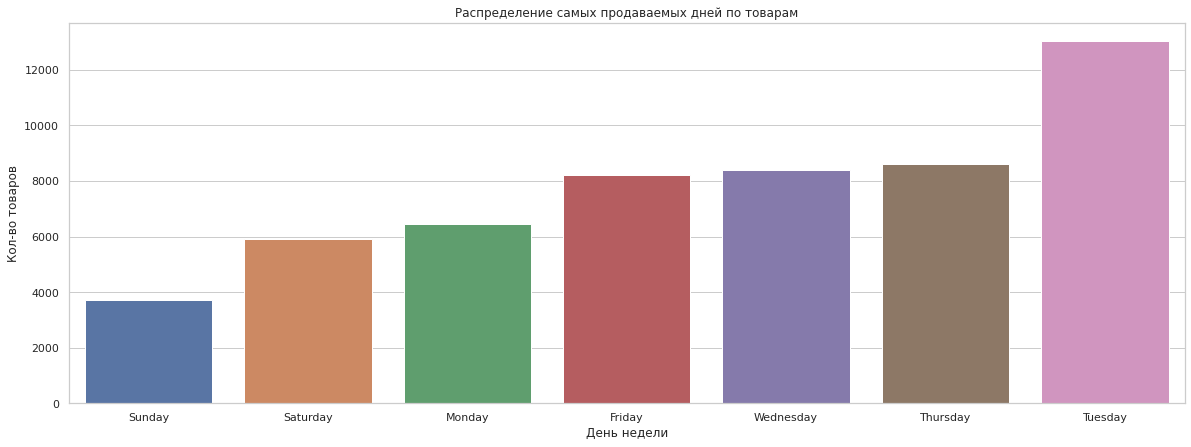

In [42]:
#суммируем данные для каждого дня недели
products_by_best_day_df_visual = most_buy_final.groupby('day_of_week', as_index=False) \
  .agg({'order_id':'sum'}).rename(columns={'order_id': 'num_of_products'}).sort_values('num_of_products')


sns.barplot(x='day_of_week', y='num_of_products', data=products_by_best_day_df_visual)
plt.title('Распределение самых продаваемых дней по товарам')
plt.xlabel('День недели')
plt.ylabel('Кол-во товаров')
     

#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  

In [43]:
customers_4 = customers.merge(orders)
customers_4 = customers_4.dropna()

In [44]:
# переводим дату в формат названия месяца
customers_4.order_approved_at = orders.order_approved_at.dt.month_name()

In [45]:
# создаем колонку 'weeks' где указываем количество недель: делим количество дней в месяце на 7
customers_4['weeks'] = orders.order_approved_at.dt.days_in_month / 7

In [46]:
customers_4.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,October,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,July,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,August,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,November,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,4.285714
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,February,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,4.000000


In [47]:
# группируем данные для расчета среднего кол-ва выполненых заказов  
customer_by_month = customers_4.query('order_status == "delivered" and order_approved_at != 0') \
    .groupby(['customer_unique_id','order_approved_at','weeks'], as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby(['customer_unique_id','order_approved_at','weeks'],as_index=False) \
    .agg({'order_id':'sum'}) \
    .rename(columns={'order_approved_at':'month_buy','order_id':'orders'})


In [48]:
# создаем колонку для расчета среднего показателя покупок у пользователей в неделю (по месяцам): делим количество заказов на количество недель
customer_by_month["avg_orders_by_week"] = customer_by_month.orders / customer_by_month.weeks

In [49]:
customer_by_month

,customer_unique_id,month_buy,weeks,orders,avg_orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,March,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,February,4.000000,1,0.250000
3,0000f6ccb0745a6a4b88665a16c9f078,May,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,October,4.428571,1,0.225806
...,...,...,...,...,...
95993,fffcf5a5ff07b0908bd4e2dbc735a684,August,4.428571,1,0.225806
95994,fffea47cd6d3cc0a88bd621562a9d061,February,4.000000,1,0.250000
95995,ffff371b4d645b6ecea244b27531430a,October,4.428571,1,0.225806
95996,ffff5962728ec6157033ef9805bacc48,February,4.000000,1,0.250000


#### 5. Когортный анализ пользователей

In [50]:
#объединяем таблицы
table_full = customers.merge(orders)
#Создадаем столбец с годом и месяцем создания заказа
table_full['order_purchase_month'] = table_full.order_purchase_timestamp.dt.strftime('%Y-%m')

In [51]:
table_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [52]:
#Определяем диапазон дат в датасете
print(table_full.order_approved_at.min())
print(table_full.order_approved_at.max())

2016-09-15 12:16:38
2018-09-03 17:40:06


ОПРЕДЕЛЯЕМ РАССМАТРИВАЕМЫЙ ПЕРИОД: так как в задании указано провести когортный анализ пользователей в период с января 
по декабрь, то мы будем рассматривать 2017 год, так как он полностью входит в рассматриваем диапазон, поскольку наши покупки
начинались с сентяря 2016 года и закончились в августе 2018. Также указываем последную дату не 2017-12, а 2018-01, чтобы
рассмотреть и декабрь 2017 полностью

In [53]:
min_date = '2017-01-01'
max_date = '2018-01-01'

In [54]:
#отбираем данные по нашему промежутку времени
table_full= table_full.query('order_approved_at >= @min_date and order_approved_at <= @max_date')
#оставляем наши покупки
table_full = table_full.query('order_status == "delivered"')
table_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09


In [55]:
#проверяем, что нет пропусков в строчке order_approved_at 
table_full.order_approved_at.isna().sum()

0

Признак формирования когорты — это действие, которое объединяет людей в группу: в нашем примере возьмем критерий первой покупки.
Определим в каком месяце была совершена первая покупка пользователем

In [56]:
first_buy = table_full.groupby('customer_unique_id', as_index=False) \
                      .agg({'order_purchase_month': 'min'}) \
                      .rename(columns={'order_purchase_month': 'first_order_month'})
first_buy.head()

,customer_unique_id,first_order_month
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


ДЕЛАЕМ КОГОРТЫ

In [57]:
#формируем датасет под создание когорт
cohort = table_full[['customer_unique_id', 'order_id', 'order_purchase_month']].merge(first_buy, on='customer_unique_id')
cohort = cohort.groupby(['first_order_month', 'order_purchase_month']) \
                .agg({'customer_unique_id': 'nunique'}) \
                .rename(columns={'customer_unique_id': 'num_of_users'})
cohort.head()

num_of_users
first_order_month order_purchase_month              
2017-01           2017-01                        716
                  2017-02                          2
                  2017-03                          2
                  2017-04                          1
                  2017-05                          3

In [58]:
#Создаем при помощи фукции отдельную колонку к датафрейму cohort_num с указанием номера месяца по диапазону окна в когорте

def cohort_num(df):
    df['num_month'] = np.arange(len(df)) + 1
    return df

# добавляем +1, чтобы избавиться от 0 в нумерации месяцев

In [59]:
cohorts = cohort.groupby('first_order_month').apply(cohort_num)
cohorts.head()

num_of_users  num_month
first_order_month order_purchase_month                         
2017-01           2017-01                        716          1
                  2017-02                          2          2
                  2017-03                          2          3
                  2017-04                          1          4
                  2017-05                          3          5

In [60]:
# новую колонку num_month переводим в индексы
cohorts.reset_index(inplace=True)
cohorts.set_index(['first_order_month', 'num_month'], inplace=True)
cohorts.head(15)

order_purchase_month  num_of_users
first_order_month num_month                                   
2017-01           1                      2017-01           716
                  2                      2017-02             2
                  3                      2017-03             2
                  4                      2017-04             1
                  5                      2017-05             3
                  6                      2017-06             1
                  7                      2017-07             3
                  8                      2017-08             1
                  9                      2017-09             1
                  10                     2017-11             3
                  11                     2017-12             1
2017-02           1                      2017-02          1616
                  2                      2017-03             3
                  3                      2017-04             5
                  4                      2017-05             2

In [61]:
# Сохраним размеры когорт по нашим месяцам
cohort_size = cohorts['num_of_users'].groupby('first_order_month').first()
cohort_size.head()

first_order_month
2017-01     716
2017-02    1616
2017-03    2503
2017-04    2257
2017-05    3451
Name: num_of_users, dtype: int64

ИЩЕМ retention
Retention — это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт. 
Retention измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.

In [62]:
#используем метод unstack, который поместит уровень индекса строк num_month из нашей таблицы cohorts в столбцы
retention = cohorts['num_of_users'].unstack('first_order_month').T.divide(cohort_size, axis=0).round(4)
retention

num_month,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,
2017-01,1.0,0.0028,0.0028,0.0014,0.0042,0.0014,0.0042,0.0014,0.0014,0.0042,0.0014
2017-02,1.0,0.0019,0.0031,0.0012,0.0043,0.0012,0.0025,0.0019,0.0006,0.0019,0.0012
2017-03,1.0,0.0044,0.0036,0.0040,0.0036,0.0016,0.0016,0.0032,0.0032,0.0008,NaN
2017-04,1.0,0.0062,0.0022,0.0018,0.0027,0.0027,0.0035,0.0031,0.0031,NaN,NaN
2017-05,1.0,0.0046,0.0046,0.0029,0.0029,0.0032,0.0041,0.0014,NaN,NaN,NaN
2017-06,1.0,0.0049,0.0040,0.0043,0.0030,0.0040,0.0036,NaN,NaN,NaN,NaN
2017-07,1.0,0.0053,0.0035,0.0024,0.0029,0.0021,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.0069,0.0035,0.0027,0.0035,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.0070,0.0055,0.0027,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 39.5, 'Номер месяца')

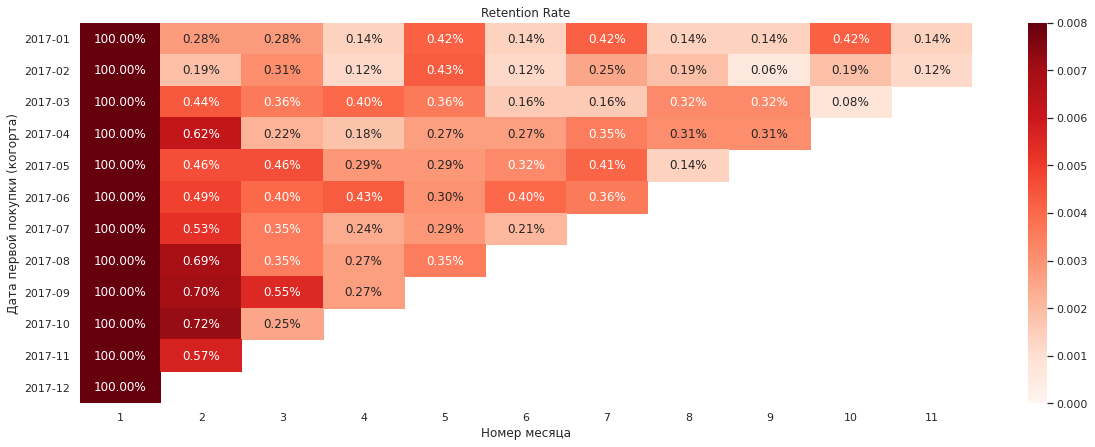

In [63]:
sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.008,cmap='Reds')
plt.title('Retention Rate')
plt.ylabel('Дата первой покупки (когорта)')
plt.xlabel('Номер месяца')

In [64]:
round(retention.div(retention.iloc[:,0], axis = 0).mul(100), 2)[3].idxmax()
#выводим когорту с максимаьным значениеем на третий месяц 

'2017-09'

In [65]:
retention[retention[3] == retention[3].max()].index
#выводим когорту с максимаьным значениеем на третий месяц другой способ

Index(['2017-09'], dtype='object', name='first_order_month')

#### 6. RFM-сегментация 

Чтобы получить оценку RFM клиента, нам нужно сначала рассчитать оценки R, F и M по шкале от худшего к лучшему.

1.рассчитать recency(недавность) = количество дней с момента последней покупки
2.рассчитать Freqency(количество) = количество покупок за исследуемый период (обычно один год)
3.рассчитать monetary(доходность) = общая сумма покупок, сделанных за исследуемый период
4.найти квинтили для каждого из этих измерений
5.дать оценку каждому параметру в зависимости от того, в каком квинтиле он находится
6.объединить баллы R, F и M, чтобы получить балл RFM
7.сопоставить оценки RF с сегментами

In [66]:
#объединяем датафреймы
full_df = customers.merge(orders)
full_df = full_df.merge(order_items)

In [67]:
#убираем пропуски
full_df = full_df.dropna()

In [68]:
#оставляем покупки 
full_df = full_df.query('order_status == "delivered"')
full_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [69]:
#временные рамки данных
print('Orders from {} to {}'.format(full_df['order_approved_at'].min(),
                                    full_df['order_approved_at'].max()))

Orders from 2016-09-15 12:16:38 to 2018-08-29 15:10:26


In [70]:
# дату для расчета R возьмем не текущую(2023 года), а день следующий за днем последний покупки
last_day = full_df.order_approved_at.max()
todays_date = last_day + timedelta(days=1)
todays_date

Timestamp('2018-08-30 15:10:26')

In [71]:
# Отбираем информацию об id заказа, датах оплаты, уникальных id покупателяей и считаем общую стоимость каждого заказа
rfm_df = full_df.groupby(['order_id', 'order_approved_at', 'customer_unique_id'], as_index=False) \
  .agg({'price': 'sum'}).sort_values('order_approved_at').rename(columns={'price': 'money'})
rfm_df.head()

,order_id,order_approved_at,customer_unique_id,money
72217,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,134.97
12025,1ff217aa612f6cd7c4255c9bfe931c8b,2016-10-04 09:43:32,14359ea0c7a105749c0a56478825b015,32.49
77347,cd3b8574c82b42fc8129f6d502690c3e,2016-10-04 10:19:23,87776adb449c551e74c13fc34f036105,29.99
89551,ed8c7b1b3eb256c70ce0c74231e1da88,2016-10-04 10:25:46,88bc832f104b6dd684a17dbb1b76e778,89.90
79228,d207cc272675637bfed0062edffd0818,2016-10-04 10:28:07,8d3a54507421dbd2ce0a1d58046826e0,119.90


In [72]:
# Для каждого пользователя найдем последнюю дату покупки, кол-во заказов (frequency) и их стоимость (monetary)
rfm_df = rfm_df.groupby('customer_unique_id', as_index=False) \
  .agg({'order_approved_at': 'max', 'order_id': 'count', 'money': 'sum'})

# Рассчитаем недавность(recency)разницу между временем от последней покупки до текущей даты (todays_date == '2018-08-30 15:10:26')
rfm_df['order_approved_at'] = rfm_df['order_approved_at'].apply(lambda x: (todays_date - x).days)

# Переименуем колонки для удобства
rfm_df= rfm_df.rename(columns={'order_approved_at': 'recency', 'order_id': 'frequency', 'money': 'monetary'})

rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [73]:
#смотрим общую инф-ию
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93336 entries, 0 to 93335
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93336 non-null  object 
 1   recency             93336 non-null  int64  
 2   frequency           93336 non-null  int64  
 3   monetary            93336 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.6+ MB


In [74]:
#смотрим на характеристику данных
rfm_df.describe()

,recency,frequency,monetary
count,93336.000000,93336.000000,93336.000000
mean,237.486093,1.033417,141.621663
std,152.569986,0.209098,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,15.000000,13440.000000


RECENCY
Разделим на 4 группы и будем считать исходя из 25, 50 и 75 процентиля. 
Кроме того, мы можем сделать вывод, что в целом количество дней с момента последней покупки свыше 25 процентиля превышает 100 дней, что свидетельствует о том, что большинство клиентов сервиса редко возвращаются к продавцу для совершения повторной покупки

In [75]:
quintiles = rfm_df.quantile([.0, .25, .50, .75]).to_dict()
quintiles

{'recency': {0.0: 1.0, 0.25: 114.0, 0.5: 219.0, 0.75: 346.0},
 'frequency': {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary': {0.0: 0.85, 0.25: 47.65, 0.5: 89.7, 0.75: 154.6925}}

In [76]:
rfm_df.recency.describe()

count    93336.000000
mean       237.486093
std        152.569986
min          1.000000
25%        114.000000
50%        219.000000
75%        346.000000
max        714.000000
Name: recency, dtype: float64

In [77]:
#формула для присвоения ранга в зависимости от указанной величины измерения
def r_score(x):
    if x <= quintiles['recency'][.25]:
        return 1
    elif x <= quintiles['recency'][.50]:
        return 2
    elif x <= quintiles['recency'][.75]:
        return 3
    else:
        return 4

In [78]:
rfm_df['R'] = rfm_df['recency'].apply(lambda x: r_score(x))
rfm_df.head()
#чем меньше ранг, тем меньше дней с момента последней покупки!!!

,customer_unique_id,recency,frequency,monetary,R
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,4
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3


Frequency
Исходя из указанных данных, мы видим, что в целом подавляющее количество покупателей совершают исключительно одну покупку (frequency),
а самое большое количество покупок равно 15, следовательно мы можем поделить наши группы по frequency на группы:
    1 - покупка
    2 - покупки
    3 - покупки
    4 и более

In [79]:
rfm_df.frequency.value_counts()

1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: frequency, dtype: int64

In [80]:
def f_score(y):
    if y == 1:
        return 1
    elif y == 2:
        return 2
    elif y == 3:
        return 3
    else:
        return 4

In [81]:
rfm_df['F'] = rfm_df['frequency'].apply(lambda y: f_score(y))
rfm_df.head()
# чем меньше ранг, тем меньше покупок!!!

,customer_unique_id,recency,frequency,monetary,R,F
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,4,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,1


Monetary
Из анализа данных по сумме заказов, мы видим, что большинство людей совершили покупки на небольшой чек, так до 75 процентиля цены относительно не сильно увеличиваются, в то время как после 75 процентиля наблюдается резкое увеличение суммы чеков, что свидетесльвует о ненормальности распределния наших значений в колонки monetary, и о том, что только небольшое количество заказов в нашем сервисе были совершены на большие чеки 

In [82]:
rfm_df.monetary.describe()

count    93336.000000
mean       141.621663
std        215.714143
min          0.850000
25%         47.650000
50%         89.700000
75%        154.692500
max      13440.000000
Name: monetary, dtype: float64

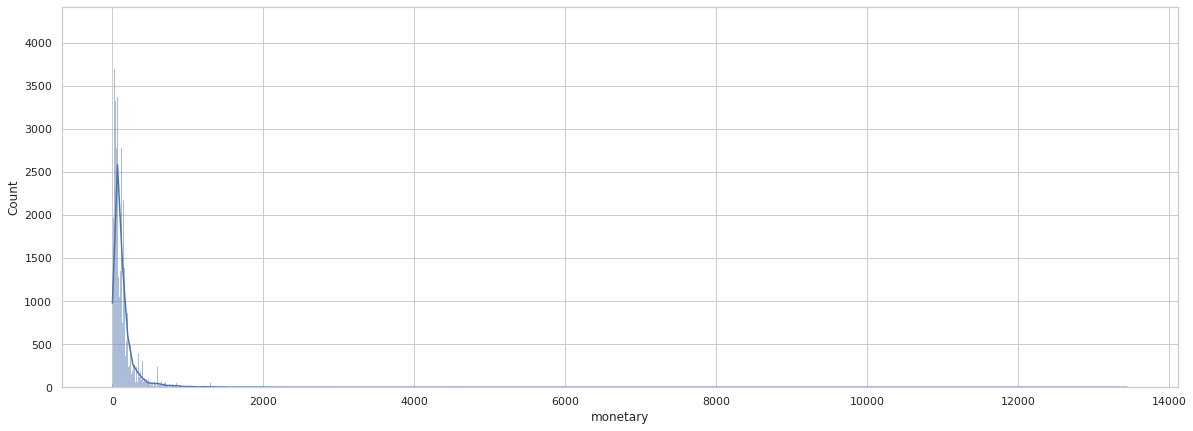

In [83]:
#распределение значений в колонке monetary: наблюдаем сосредоточенность бол-ва данных в левой части графика и длинный хвост вправо
sns.histplot(rfm_df.monetary, kde=True)

! Примечание: делить группы из данного столбца по обычным квантилям мы не будем, так как при таком деление получаются 4 группы приблизительно в одинаковым количеством пользователей, что логически не совпадает с действительностью и тем, какой смысл мы вкладываем в разделение наших рангов по цене.
   В связи с чем, сначала определим нижнюю границу наших данных, значения выше которых будут подходить под самый низкий ранг (1 - самые недорогие покупки). Их должно быть больше всего.

!!! Методом проб и ошибок вышли на 75 процентиль, берем значение меньше него для одного ранга, потом отсекаем и снова берем.
С 50 процентилем значение 1 ранга было слишком низким, да и граница 4 ранга не была столько высока, как нам необходимо было для более точного анализа выявления самых дорогих покупок. 

In [84]:
# ищу 75 процентиль, беру меньше него
rfm_df.loc[rfm_df.monetary > rfm_df.monetary.quantile(0.75)].monetary.describe()

count    23334.000000
mean       354.235637
std        348.247490
min        154.700000
25%        189.000000
50%        240.000000
75%        369.900000
max      13440.000000
Name: monetary, dtype: float64

In [85]:
# ищу 75 процентиль, беру меньше него и отсекаю 75 процентиль из варинта выше
rfm_df.loc[rfm_df.monetary > 369.900000].monetary.describe()

count     5827.000000
mean       739.005298
std        527.560786
min        369.980000
25%        439.980000
50%        580.270000
75%        828.495000
max      13440.000000
Name: monetary, dtype: float64

In [86]:
rfm_df.loc[rfm_df.monetary > 828.495000].monetary.describe()

count     1457.000000
mean      1368.410357
std        733.369840
min        829.000000
25%        949.990000
50%       1174.980000
75%       1549.000000
max      13440.000000
Name: monetary, dtype: float64

In [87]:
#границы для рангов
m_1 = rfm_df.monetary.quantile(0.75)
m_2 = rfm_df.loc[rfm_df.monetary > m_1].monetary.quantile(0.75)
m_3 = rfm_df.loc[rfm_df.monetary > m_2].monetary.quantile(0.75)
print(m_1, m_2, m_3, sep = '\n')

154.6925
369.9
828.495


In [88]:
def m_score(z):
    if z < m_1:
        return 1
    elif z >= m_1 and z < m_2:
        return 2
    elif z >= m_2 and z < m_3:
        return 3
    else:
        return 4

In [89]:
rfm_df['M'] = rfm_df['monetary'].apply(lambda z: m_score(z))
rfm_df
#чем больше сумма, тем больше РАНГ!!!

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,4,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,1,2
...,...,...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00,4,1,4
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,3,1,1
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90,4,1,1
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00,2,1,1


ГРАНИЦЫ МЕТРИК

In [90]:
#создаем переменные под каждую метрику, считаем сколько значений по каждому рангу, преобразуем в формат таблицы
r_value_counts =  rfm_df.R.value_counts().to_frame().reset_index()
f_value_counts =  rfm_df.F.value_counts().to_frame().reset_index()
m_value_counts =  rfm_df.M.value_counts().to_frame().reset_index()

#объединяем наши колонки в одну таблицу
rmf_value_counts = r_value_counts.merge(f_value_counts, on='index').merge(m_value_counts, on='index') \
  .sort_values('index')

rmf_value_counts

,index,R,F,M
0,1,23695,90536,70002
1,2,23276,2572,17462
3,3,23120,181,4415
2,4,23245,47,1457


Соединяем значения наших R,F,M 

In [91]:
rfm_df['RFM_Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,1,1,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,537,1,69.00,4,1,1,411
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,1,1,311
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,1,2,312


In [92]:
#смотрим какие уникальные значения RFM_Score у нас получились
rfm_df.RFM_Score.unique()

array(['111', '411', '311', '312', '211', '213', '412', '112', '212',
       '113', '313', '322', '114', '214', '413', '121', '314', '421',
       '222', '414', '123', '124', '122', '422', '221', '321', '133',
       '223', '131', '423', '431', '323', '132', '224', '232', '144',
       '333', '324', '231', '332', '243', '441', '233', '331', '334',
       '134', '432', '143', '433', '244', '424', '142', '242', '234',
       '443', '343', '344', '342'], dtype=object)

In [93]:
#общее количество уникальных значений RFM_Score
rfm_df.RFM_Score.nunique()

58

In [94]:
#количество пользователей по сегментам
RFM_results = rfm_df.groupby('RFM_Score',as_index=False) \
    .agg({'customer_unique_id':'count'})
RFM_results.head()

,RFM_Score,customer_unique_id
0,111,17456
1,112,4068
2,113,1009
3,114,368
4,121,282


Text(0, 0.5, 'Кол-во клиентов')

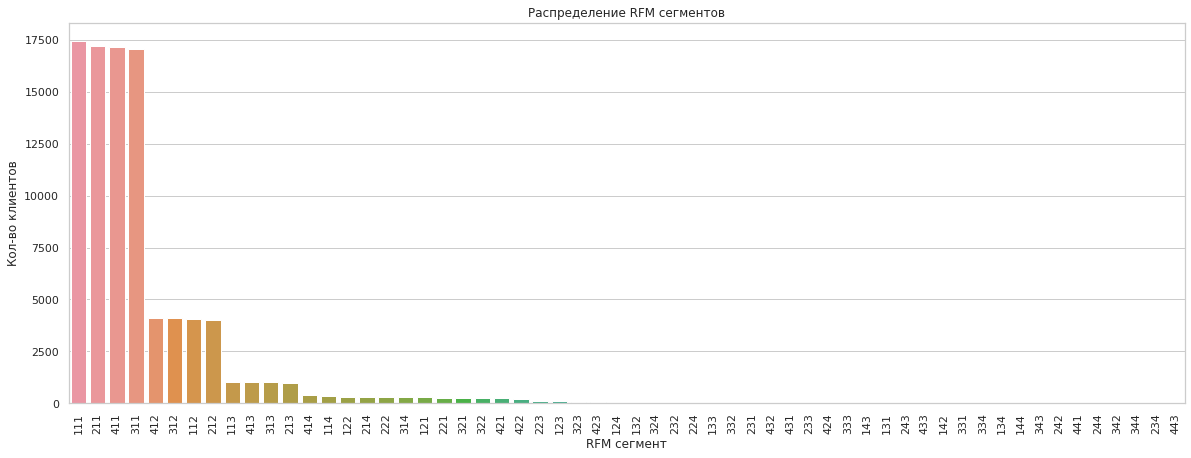

In [95]:
rfm_score_count = rfm_df.RFM_Score.value_counts().to_frame().reset_index() \
  .rename(columns={'RFM_Score': 'num_of_people', 'index': 'RFM_Score'}) \
  .sort_values('num_of_people', ascending=False)

sns.barplot(data=rfm_score_count, x='RFM_Score', y='num_of_people')
plt.xticks(rotation=90)
plt.title('Распределение RFM сегментов')
plt.xlabel('RFM сегмент')
plt.ylabel('Кол-во клиентов')
     

Расшифровка:
RECENCY
1-покупка совершена в течение 114 дней от "текущей даты" 
2-покупка совершена от 114 до 219 дней от "текущей даты"
3-покупка совершена от 219 до 346 дней от "текущей даты"
4-покупка совершена свеше 346 дней от "текущей даты"


Frequency
1 - 1 покупка
2 - 2 покупки
3 - 3 покупки
4 - 4 и более

Monetary
1- цена покупки до 155.
2- цена покупки от 155 до 370.
3- цена покупки от 370 до 829.
4- цена покупки свыше 829
! значения округлены

На основе показателей RFM составляем 8 сегментов клиентов

In [96]:
segt_map = {
    r'411': 'Потерянные клиенты',
    r'41[3-4]': 'Потерянные доходные клиенты',
    r'4[1-4][1-4]': 'Спящие клиенты',
    r'31[1-4]': 'Под риском',
    r'3[2-4][1-4]': 'Спящие лояльные клиенты',
    r'21[1-4]': 'Клиенты, требующие внимания',
    r'2[2-4][1-4]': 'Перспективные клиенты',
    r'11[1-4]': 'Недавние клиенты',
    r'1[2-4][1-4]': 'Лояльные клиенты'
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)

In [114]:
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,1,1,111,Недавние клиенты
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1,1,1,111,Недавние клиенты
2,0000f46a3911fa3c0805444483337064,537,1,69.00,4,1,1,411,Потерянные клиенты
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,1,1,311,Под риском
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,1,2,312,Под риском


In [97]:
rfm_df.Segment.value_counts()

Недавние клиенты               22901
Клиенты, требующие внимания    22518
Под риском                     22448
Потерянные клиенты             17182
Спящие клиенты                  4677
Потерянные доходные клиенты     1386
Лояльные клиенты                 794
Перспективные клиенты            758
Спящие лояльные клиенты          672
Name: Segment, dtype: int64

In [98]:
rfm_df_SEGMENT = rfm_df.Segment.value_counts().to_frame().reset_index()

Text(0, 0.5, 'Кол-во клиентов')

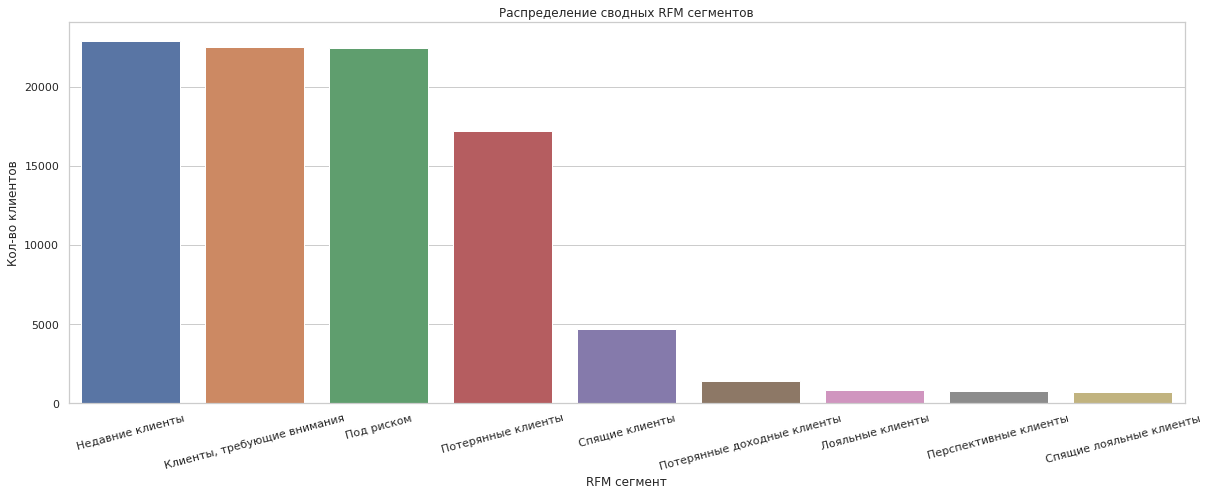

In [99]:
sns.barplot(data=rfm_df_SEGMENT, x='index', y='Segment')
plt.xticks(rotation=15)
plt.title('Распределение сводных RFM сегментов')
plt.xlabel('RFM сегмент')
plt.ylabel('Кол-во клиентов')

### Выводы

По результатам исследования данных маркетплейса/интернет-магазина можно прийти к следующим выводам. Большая часть всех покупателей не совершают более 1 покупки и не возвращаются обратно, следовательно имеются явные проблемы с удержанием потребителей.Следовательно одна из основных задач, которую нужно решить — это разработка (или улучшение) системы лояльности для удержания клиентов.

Кроме того, у компании имеются потерянные доходные клиенты,спящие лояльные клиенты, которых стоит попытаться вернуть с помощью различных коммерческих предложений. А также особое внимание стоит уделить категории "кленты, требующие внимания", поскольку эти клиенты относительно недавно совершили покупку в данном торговом предприятии и нужно их заинтересовать, для того, чтобы они вернулись обратно